<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/project4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Resources
- Python https://liangfgithub.github.io/Python_W13_Movie_RS.html
- R: https://liangfgithub.github.io/Rcode_W13_Movie_EDA.nb.html

MovieLens and Recommender System


Exploratory Data Analysis
Download the MovieLens 1M Dataset. You’ll find four files: README, movies.dat, ratings.dat, and users.dat. Check the readme file to understand the format of the other three files.
https://grouplens.org/datasets/movielens/1m/

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [28]:
import pandas as pd
import numpy as np

##Libraries

In [15]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357286 sha256=8e83e1d74079fa2fb484c3748ea19516feaa390052f6a1a564cf0c233a2b622f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [18]:
DATA_DIR=f"/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Dataset/ml-1m"

In [19]:

ratings = pd.read_csv(f'{DATA_DIR}/ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv(f'{DATA_DIR}/movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']


In [8]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [9]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Explore the relationship between movie ratings and movie genres. First, simplify movie genres: multiple genres to ‘Multiple’.

In [20]:
multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

In [11]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Multiple
1,2,Jumanji (1995),Multiple
2,3,Grumpier Old Men (1995),Multiple
3,4,Waiting to Exhale (1995),Multiple
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Then merge ratings and movie datasets.



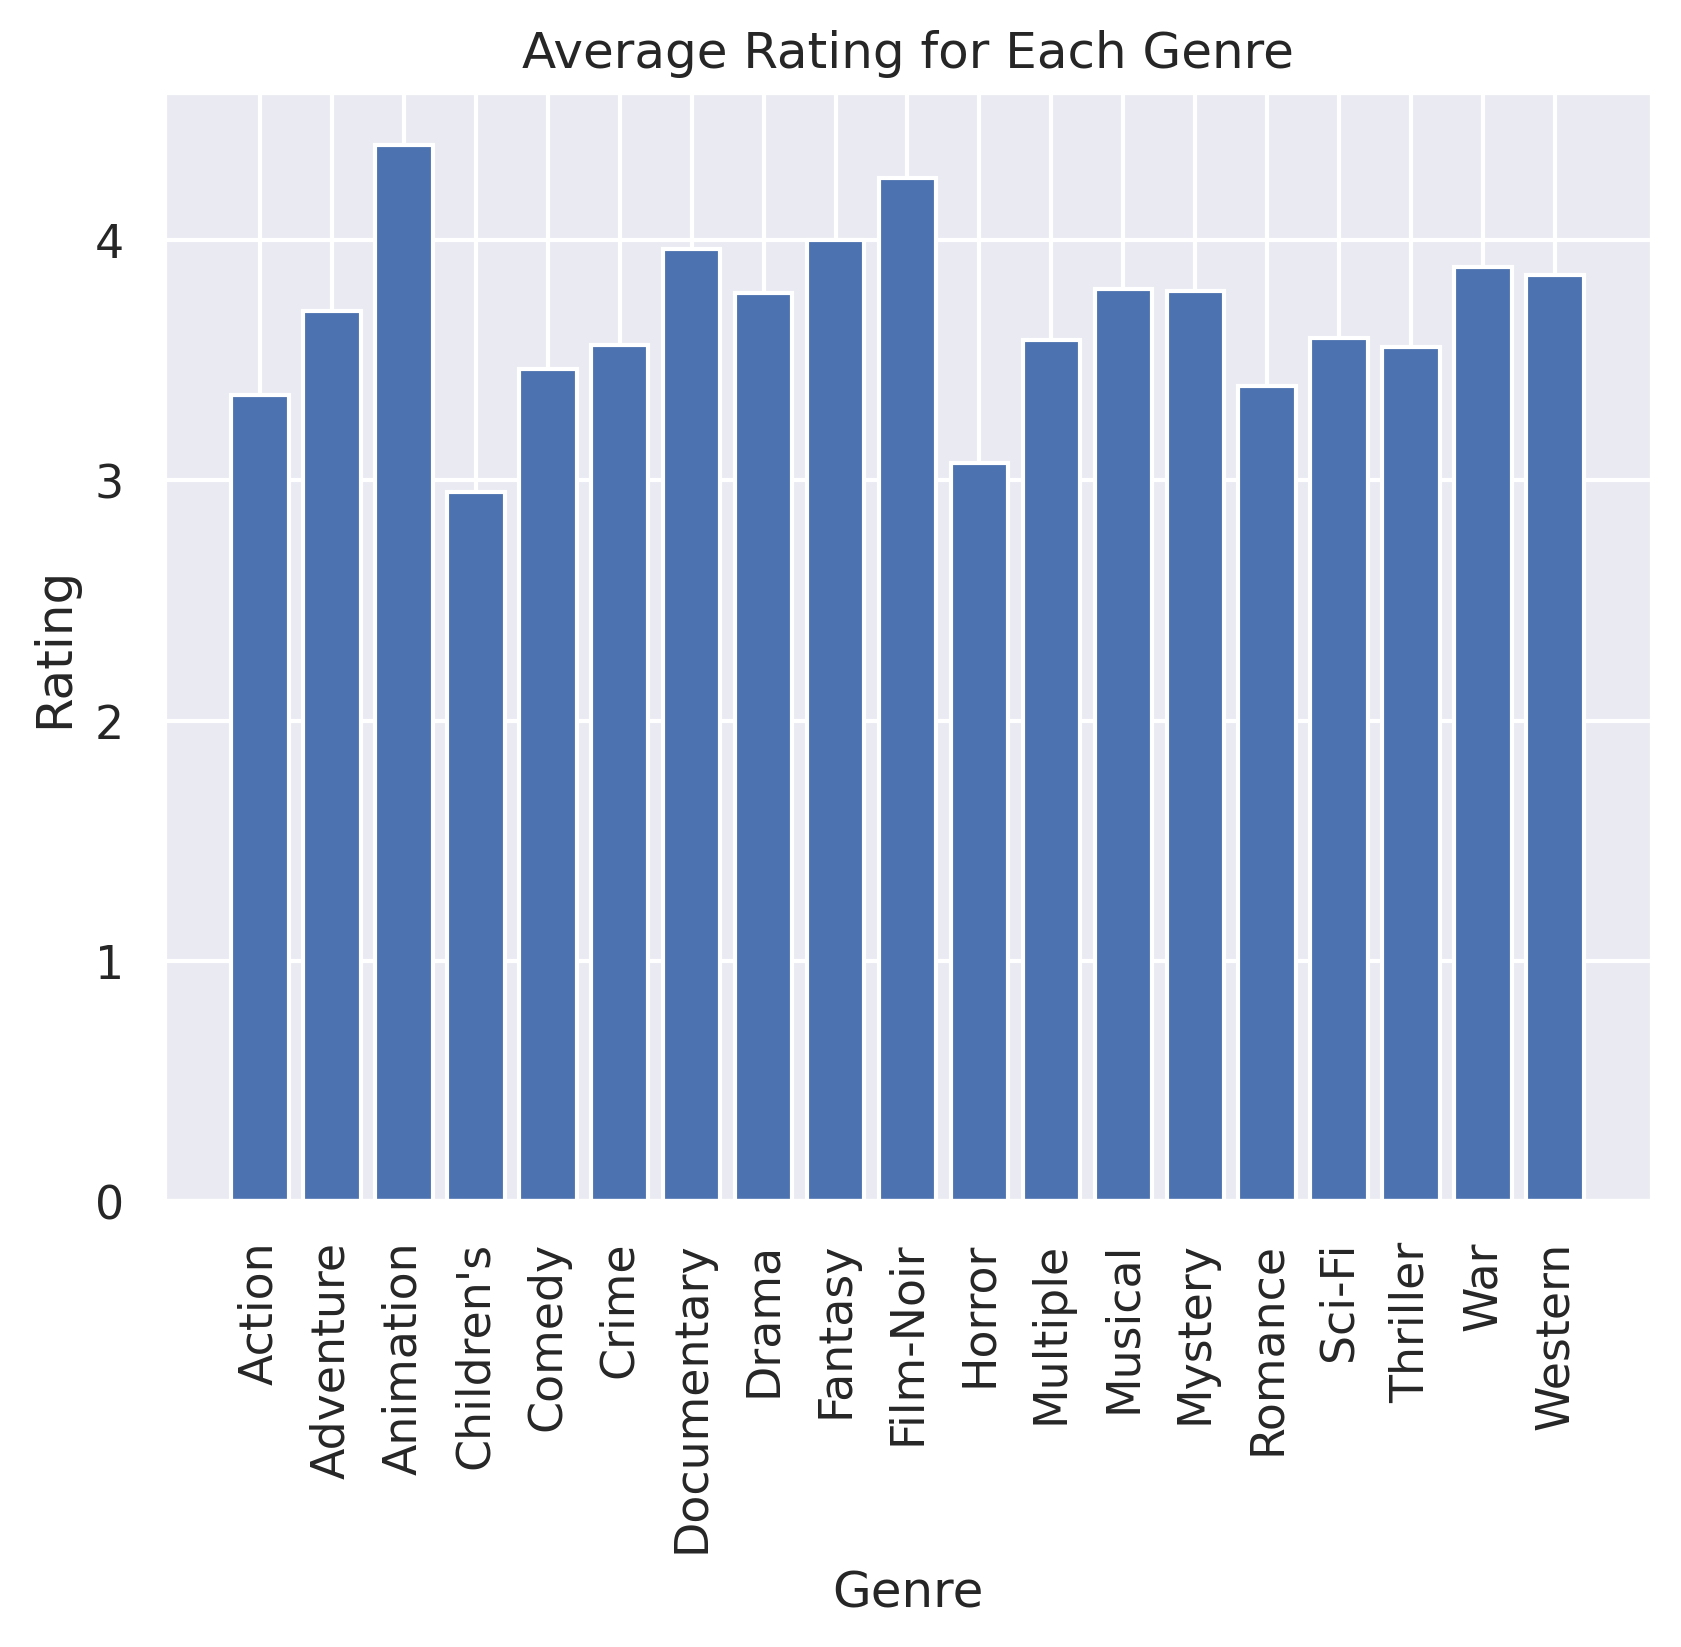

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()

plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

Recommender System


We train a recommender system and make prediction on the test data. We will use the surprise library. First, we must create a dataset object. To do so, we start with a dataframe with columns itemID, userID and rating and use the load_from_df method.



In [22]:
from surprise import Dataset, Reader
ratings = ratings.drop('Timestamp', axis = 1)
ratings.columns = ['userID', 'itemID', 'rating']
ratings = ratings[['itemID', 'userID', 'rating']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userID", "itemID", "rating"]], reader)

In [24]:
ratings

,itemID,userID,rating
0,1193,1,5
1,661,1,3
2,914,1,3
3,3408,1,4
4,2355,1,5
...,...,...,...
1000204,1091,6040,1
1000205,1094,6040,5
1000206,562,6040,5
1000207,1096,6040,4


In [25]:
data

Next, we will split the data into a train and test.



In [26]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size = 0.25)


We'll use the user-based collaborative filtering method with cosine similarity and normalization.



In [27]:
from surprise.prediction_algorithms.knns import KNNWithZScore
sim_options = {'name': 'cosine', 'user_based': True}
algo = KNNWithZScore(sim_options=sim_options).fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


Now let’s make prediction on the test data:



In [29]:
preds = [algo.predict(uid, iid).est for uid, iid, _ in testset]
results_table = pd.DataFrame(np.stack([testset])[0],
                             columns = ['itemID', 'userID', 'rating'])
results_table['predicted'] = preds
results_merged = results_table.merge(movies,
                                     left_on = 'itemID', right_on = 'MovieID')
results_merged = results_merged.drop('itemID', axis = 1)
results_merged.sort_values('userID')

,userID,rating,predicted,MovieID,Title,Genres
67455,1.0,5.0,3.837818,182,Moonlight and Valentino (1995),Multiple
2229,1.0,4.0,2.950228,1449,Waiting for Guffman (1996),Comedy
156753,1.0,3.0,2.683416,2010,Metropolis (1926),Sci-Fi
119959,1.0,3.0,2.569243,2106,Swing Kids (1993),Multiple
57507,1.0,3.0,4.573525,1728,"Winter Guest, The (1997)",Drama
...,...,...,...,...,...,...
11110,3952.0,4.0,4.360021,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Multiple
63279,3952.0,4.0,3.510803,2208,"Lady Vanishes, The (1938)",Multiple
77718,3952.0,3.0,2.888409,746,Force of Evil (1948),Film-Noir
146716,3952.0,3.0,2.672782,2033,"Black Cauldron, The (1985)",Multiple
